# Titanic dataset: cleaning
(Kaggle challenge)
In this notebook, we will be covering all of the steps required to wrangle the Titanic data set into a format that is suitable for machine learning.   
We will do each of the following:
  - impute missing values
  - create new features (feature engineering)


<a id="loading"></a>
# 1. Load packages and data
First step, as always, is to import the necessary Python packages and load the input data as a Pandas dataframe.

I chose to combine the train and test set into one. Since we will have to impute some missing age and fare values, I prefer to do this across the entire dataset, rather than separately across train and test sets. 

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (12,8)})

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# print(os.listdir("../input"))

In [9]:
# Load data as Pandas dataframe
df = pd.read_csv("titanic.csv")

In [10]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


In [12]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

<a id="impute-missing"></a>
# 2. Imputation 
We can see above that there are a few columns with missing values. The `Cabin` column is missing over 1000 values, so we won't use that for predictions, but the `Age`, `Embarked` and `Fare` columns are all complete enough that we can fill in the missing values through imputation.   
<a id="age"></a>
## 2.1. Impute missing age values
A simple option for the missing age values is to use the median age value. Let's go a little further and use each passenger's *Title* to estimate their age. E.g. if a passenger has the title of *Dr*, I will give them the median age value for all other passengers with the same title.

### Extract title from name
We can use a regular expression, a multiple check or other way to extract the title from the `Name` column. We will do this by finding the adjacent letters that are immediately followed by a full stop.


In [13]:
# create new Title column
df["Title"] = df["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
print(df.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Title  
0      0         A/5 21171   7.2500   NaN        S    Mr  
1      0          PC 17599  71.2833   C85        C   Mrs  
2      0  STON/O2. 3101282   7.9250   NaN        S  Miss  
3      0            113803  53.1000  C123        S   Mrs  
4      0            37345

In [14]:
import re
#creating new title column different way
df['Name']

#write a regular expression that will find a title in the name eg the letter starting from a capital letter ending with
#w. and then createa a new column in the data frame (df['name of column'] = something)
#if you use regular expression, u can use the re.search(function (then import re))



result = re.search(r'Dr', 'James Willis, Dr')
print(result)
string2 = "Francine Mrs. Clemence"
string1 = "Surname, Mrs. FirtName"
df["Name"].str.extract("([A-Za-z]+)\.")

df['Title'] = df['Name'].apply(lambda namestring: namestring.split(",")[1].split()[0])              #not sure

<re.Match object; span=(14, 16), match='Dr'>


In [15]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


### Use only the most common titles
Let's take a look at the unique titles across all passengers:

In [16]:
df['Title'].value_counts()
# the means are important, we need to identify the most common names and then put them there. si

df[ df['Title'] == 'Mr.' ]['Age'].dropna().mean()

32.368090452261306

In [17]:
df[ df['Title'] == 'Master.' ]['Age'].dropna().mean()

4.574166666666667

In [20]:
df[ df['Title'] == 'Miss.' ]['Age'].dropna().mean()

21.773972602739725

In [18]:
df[ df['Title'] == 'Mrs.' ]['Age'].dropna().mean()

35.898148148148145

In [21]:
df['Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
the            1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Title, dtype: int64

As we can see above, there are quite a few different titles. However, many of these titles are just French versions of the more common English titles, e.g. Mme = Madame = Mrs.   

We will use the six most common titles, replacing all other titles with the most appropriate of these six.

In [ ]:
#we agreed that the common ones are Mr master Mrs Miss Dr and Rev

In [22]:
# replace rare titles with more common ones
map_Titles = {
    "Mlle.": "Miss.",
    "Ms.": "Miss.",
    "Mme.": "Mrs.",
    "Lady.": "Mrs.",
    "Countess": "Mrs.",
    "Capt.": "Mr.",
    "Col.": "Mr.",
    "Don.": "Mr.",
    "Major.": "Mr.",
    "Sir.": "Mr.",
    "the.": "Mrs.",
    "Jonkheer.": "Mr."
}
df.replace( { "Title": map_Titles}, inplace = True)

In [23]:
# confirm that we are left with just six values
df['Title'].value_counts()

Mr.        525
Miss.      185
Mrs.       127
Master.     40
Dr.          7
Rev.         6
the          1
Name: Title, dtype: int64

### Use median of title group
Now, for each missing age value, we will impute the age using the median age for all people with the same title.

In [24]:

# impute missing Age values using median of Title groups
df["Age"].isna()
df["Age"] = df.groupby("Title")["Age"].transform(lambda x: x.fillna(x.median()))


# create a column of the average ages
mean_age = df["Age"].mean()
# replace all missing ages with the value in this column
df["Age"].fillna(mean_age, inplace=True)


In [25]:

#different version
#for titlegroup in df.groupby( ["Title"] ):
#  print(titlegroup[0])
#del df['age_med']

title_medians = {titlegroup[0]: titlegroup[1]['Age'].dropna().median() for titlegroup in df.groupby(["Title"])}

title_medians

<ipython-input-25-386c363e45e9>:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  title_medians = {titlegroup[0]: titlegroup[1]['Age'].dropna().median() for titlegroup in df.groupby(["Title"])}


{'Dr.': 46.5,
 'Master.': 3.5,
 'Miss.': 21.0,
 'Mr.': 30.0,
 'Mrs.': 35.0,
 'Rev.': 46.5,
 'the': 33.0}

We can visualize the median ages for each title group. Below, we see that each title has a distinctly different median age. 
> **Note**: There is no risk in doing this after imputation, as the median of an age group has not been affected by our actions.

<ipython-input-26-539f0cf5574a>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Title', y='Age', data=df, estimator=np.median, ci=None, palette='Blues_d')


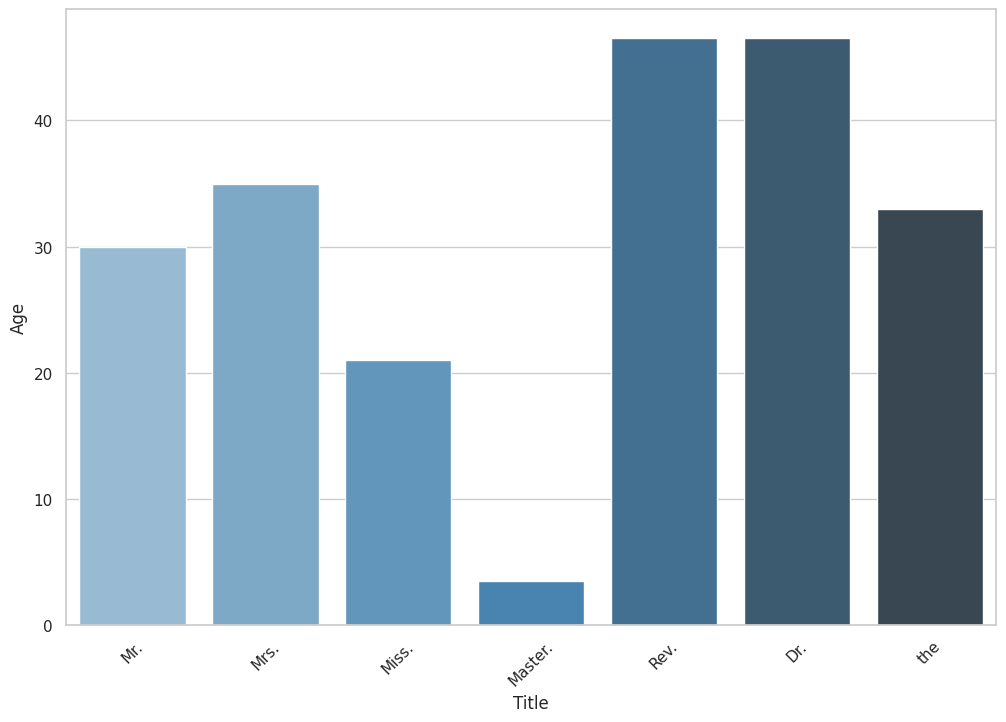

In [26]:
sns.barplot(x='Title', y='Age', data=df, estimator=np.median, ci=None, palette='Blues_d')
plt.xticks(rotation=45)
plt.show()

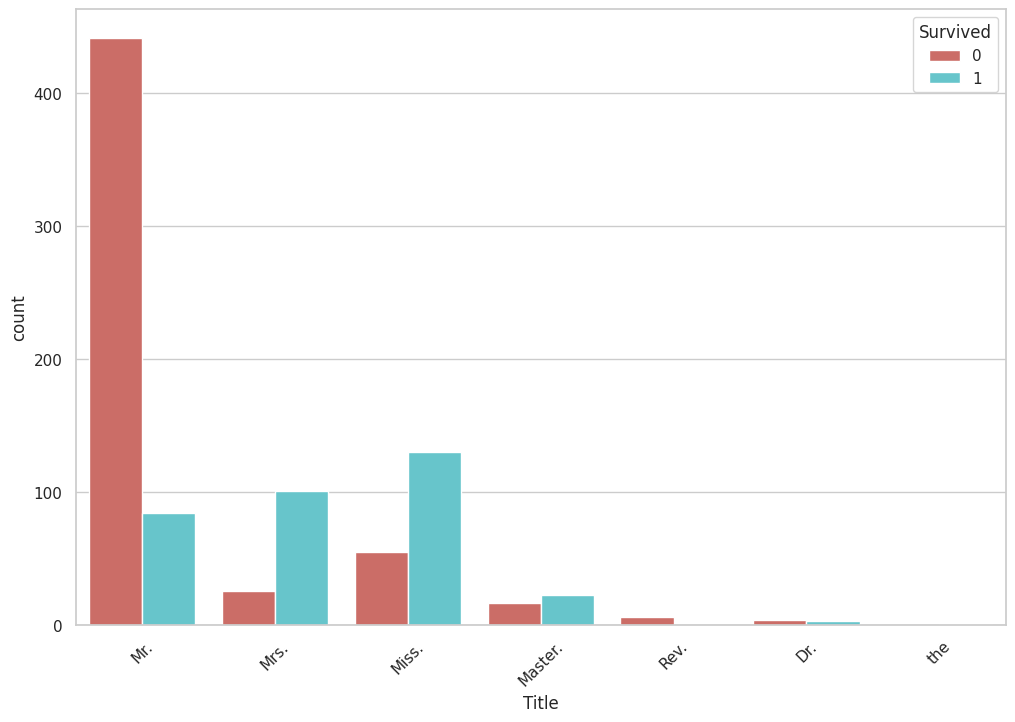

In [27]:
sns.countplot(x='Title', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

<a id="fare"></a>
## 2.2. Impute missing fare values
For the single missing fare value, I also use the median fare value for the passenger's class.   

> Perhaps you could come up with a cooler way of visualising the relationship between the price a passenger paid for their ticket and their chances of survival?

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 32.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 46.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 13.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


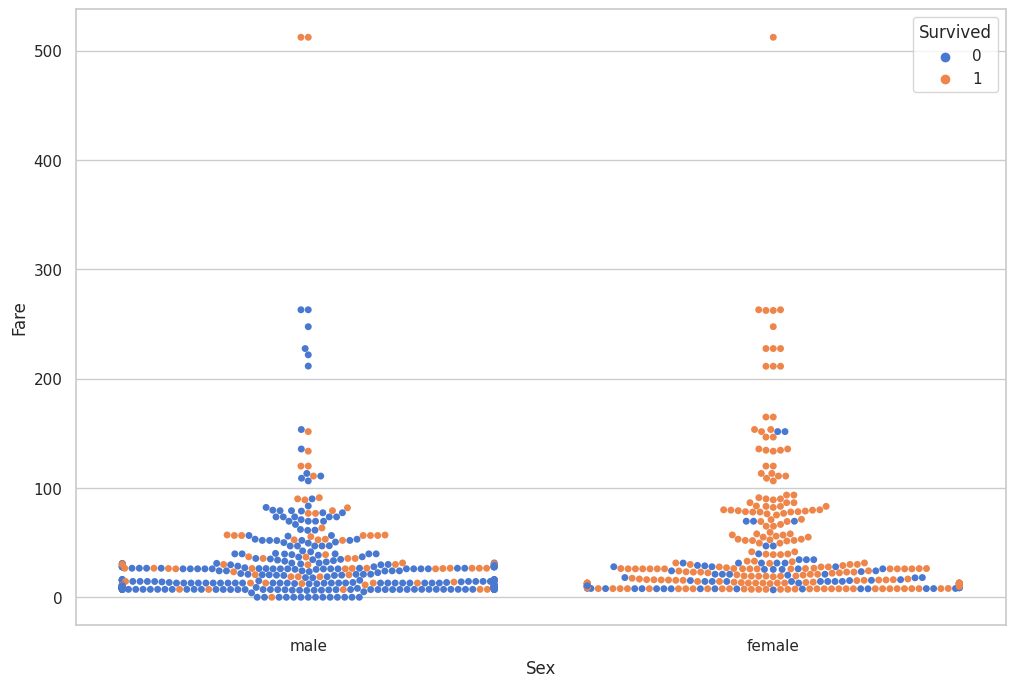

In [28]:
sns.swarmplot(x='Sex', y='Fare', hue='Survived', data=df)
plt.show()

In [31]:
# impute missing Fare values using median of Pclass groups
# create a column of the average fares
fare_med = df.groupby('Pclass')['Fare'].median()
df['Fare'] = df['Fare'].fillna(df['Pclass'].map(fare_med))


# replace all missing fares with the value in this column

#del df['fare_med']

<a id="embarked"></a>
## 2.3. Impute missing "embarked" value
There are also just two missing values in the `Embarked` column. Here we will just use the Pandas 'backfill' method.


<ipython-input-32-064573f5a383>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(x='Embarked', y='Survived', data=df,


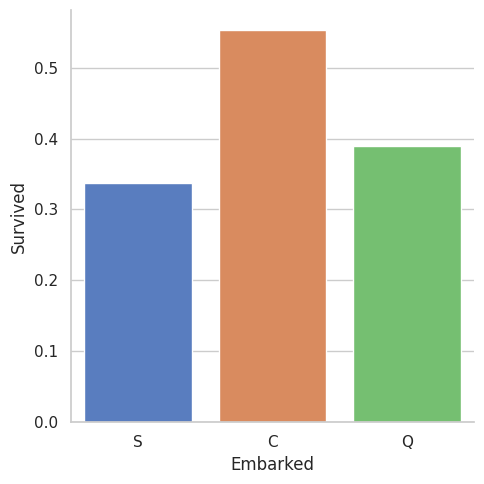

In [32]:
sns.catplot(x='Embarked', y='Survived', data=df,
            kind='bar', palette='muted', ci=None)
plt.show()

In [33]:
df['Embarked'].fillna(method='backfill', inplace=True)

<a id="feature-engineering"></a>
# 3. Add family size column
We can use the two variables of **Parch** and **SibSp** to create a new variable called **Family_Size**. This is simply done by adding `Parch` and `SibSp` together.

In [34]:
# create Family_Size column (Parch + SibSp)

df['Family_Size'] = df['Parch'] + df['SibSp']

In [35]:
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,891.0,NaN,NaN,NaN,29.390202,13.265322,0.42,21.0,30.0,35.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


# 4. Save cleaned version
Finally, let's save our cleaned data set so we can use it in other notebooks.

In [36]:
cleaned_data_file = 'cleaned_data.csv'  # Specify the filename for the cleaned dataset
df.to_csv(cleaned_data_file, index=False)